In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas_datareader.data as reader
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

In [9]:
end = dt.datetime.now()
start = dt.date(end.year - 8, end.month, end.day)
cryptolist = ['AAVE-USD', 'BNB-USD', 'BTC-USD', 'LINK-USD','ADA-USD','ETH-USD', 'SOL-USD', 'USDT-USD', 'UNI1-USD']
df = reader.get_data_yahoo(cryptolist, start, end)['Adj Close']

end1 = dt.date(end.year - 1, end.month, end.day) #1 years back

##changing date accordingly if early half vs late half of the year
if (end.month <=6):
    end2 = dt.date(end.year-1, 6+end.month, end.day) #6 months back
else:
    end2 = dt.date(end.year, end.month-6, end.day)
    
##setting start date to 3 years before the end dates
start1 = dt.date(end1.year - 3, end.month, end.day) #3 years before end1

#final start and end for future prediction
startfinal = dt.date(end.year-3, end.month, end.day) # 3 years before now
endfinal = dt.date(end.year, end.month, end.day) #now

##getting 3 datasets, df1 and df2 for backtest prediction, while df is for future prediction
df1 = reader.get_data_yahoo(cryptolist, start1, end1)['Adj Close']
df2 = reader.get_data_yahoo(cryptolist, start1, end2)['Adj Close']
df = reader.get_data_yahoo(cryptolist, startfinal, endfinal)['Adj Close']


In [10]:
##resetting the indexes of the dataset
##run this ONLY ONCE

df1 = df1.reset_index()
df2 = df2.reset_index()
df = df.reset_index()

In [11]:
df1[['ds', 'y']] = df1[['Date', 'BTC-USD']]

In [12]:
df2[['ds', 'y']] = df2[['Date', 'BTC-USD']]
df[['ds', 'y']] = df1[['Date', 'BTC-USD']]

In [21]:
##scale all the data from 0 to 1
def preparation(data):
    crypto_currency = data.iloc[0][1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['BTC-USD'].values.reshape(-1,1))
    days = 60
    prediction_day = 30
    x_train, y_train = [], []
    for x in range(days,len(data)-prediction_day):
        x_train.append(scaled_data[x-days:x,0])
        y_train.append(scaled_data[x+prediction_day,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    ##neural network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences= True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units =50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units =1))
    model.compile(optimizer='adam',loss = 'mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size = 32)
    #testing
    test_data = data.iloc[int(len(data)*(3/4)):-1]
    actual_prices = test_data['BTC-USD'].values
    total_dataset = pd.concat((data['BTC-USD'],test_data['BTC-USD']),axis=0)
    model_inputs = total_dataset[len(total_dataset)-len(test_data)-days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.fit_transform(model_inputs)
    x_test = []

    for x in range(days, len(model_inputs)):
        x_test.append(model_inputs[x-days:x,0])


    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    predict_prices = model.predict(x_test)
    predict_prices = scaler.inverse_transform(predict_prices)
    plt.figure(figsize = (25,10))
    plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
    plt.plot(predict_prices, color = 'blue', label = 'Prediction Prices')
    plt.title('BTC price prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()
    ##to predict the next month
    real_data = [model_inputs[len(model_inputs) - days:len(model_inputs) +1,0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
    prediction_value = model.predict(real_data)
    prediction_value = scaler.inverse_transform(prediction_value)
    return (prediction_value)

Epoch 1/25
32/32 [==============================] - 9s 69ms/step - loss: 0.0224
Epoch 2/25
32/32 [==============================] - 2s 68ms/step - loss: 0.0068
Epoch 3/25
32/32 [==============================] - 2s 66ms/step - loss: 0.0049
Epoch 4/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0042
Epoch 5/25
32/32 [==============================] - 2s 74ms/step - loss: 0.0037
Epoch 6/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0038
Epoch 7/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0033
Epoch 8/25
32/32 [==============================] - 3s 78ms/step - loss: 0.0035
Epoch 9/25
32/32 [==============================] - 2s 67ms/step - loss: 0.0033
Epoch 10/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0031
Epoch 11/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0028
Epoch 12/25
32/32 [==============================] - 2s 78ms/step - loss: 0.0029
Epoch 13/25
32/32 [==================

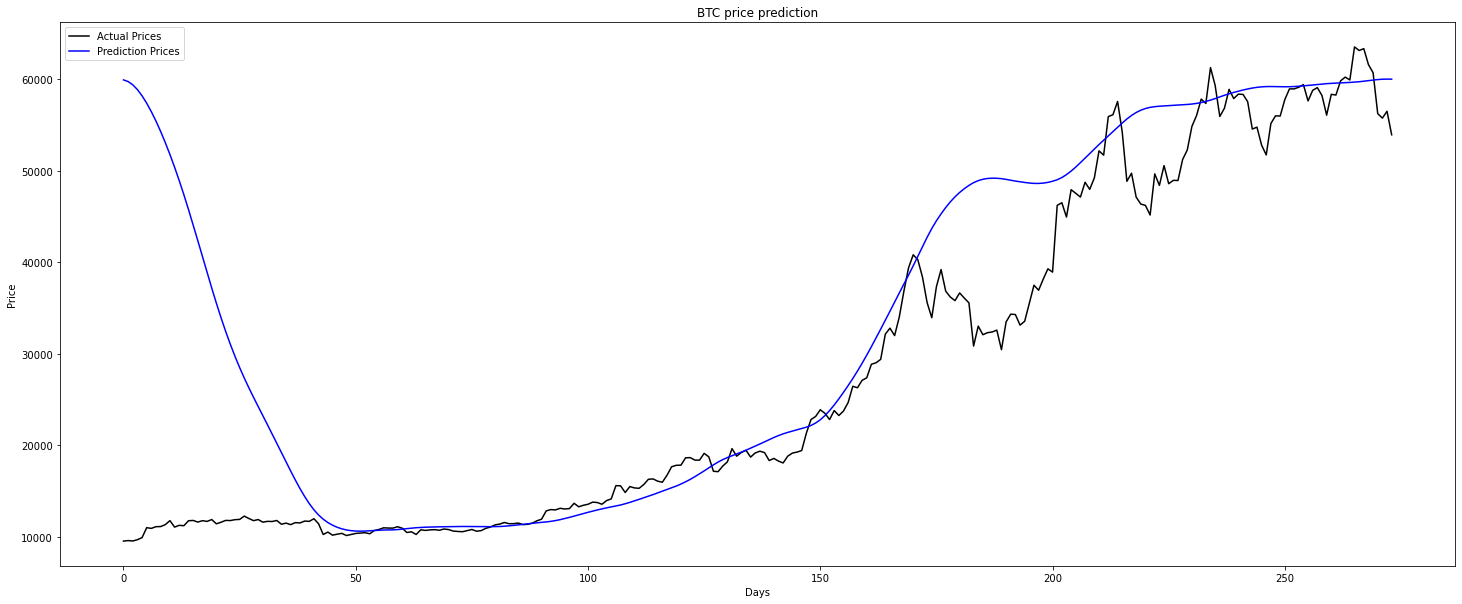

array([[59950.336]], dtype=float32)

In [22]:
preparation(df1)
#1 year

Epoch 1/25
38/38 [==============================] - 11s 69ms/step - loss: 0.0288
Epoch 2/25
38/38 [==============================] - 3s 68ms/step - loss: 0.0114
Epoch 3/25
38/38 [==============================] - 3s 65ms/step - loss: 0.0098
Epoch 4/25
38/38 [==============================] - 2s 65ms/step - loss: 0.0090
Epoch 5/25
38/38 [==============================] - 3s 67ms/step - loss: 0.0089
Epoch 6/25
38/38 [==============================] - 2s 66ms/step - loss: 0.0068
Epoch 7/25
38/38 [==============================] - 2s 64ms/step - loss: 0.0066
Epoch 8/25
38/38 [==============================] - 3s 83ms/step - loss: 0.0059
Epoch 9/25
38/38 [==============================] - 2s 62ms/step - loss: 0.0053
Epoch 10/25
38/38 [==============================] - 2s 63ms/step - loss: 0.0055
Epoch 11/25
38/38 [==============================] - 2s 65ms/step - loss: 0.0053
Epoch 12/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0063
Epoch 13/25
38/38 [=================

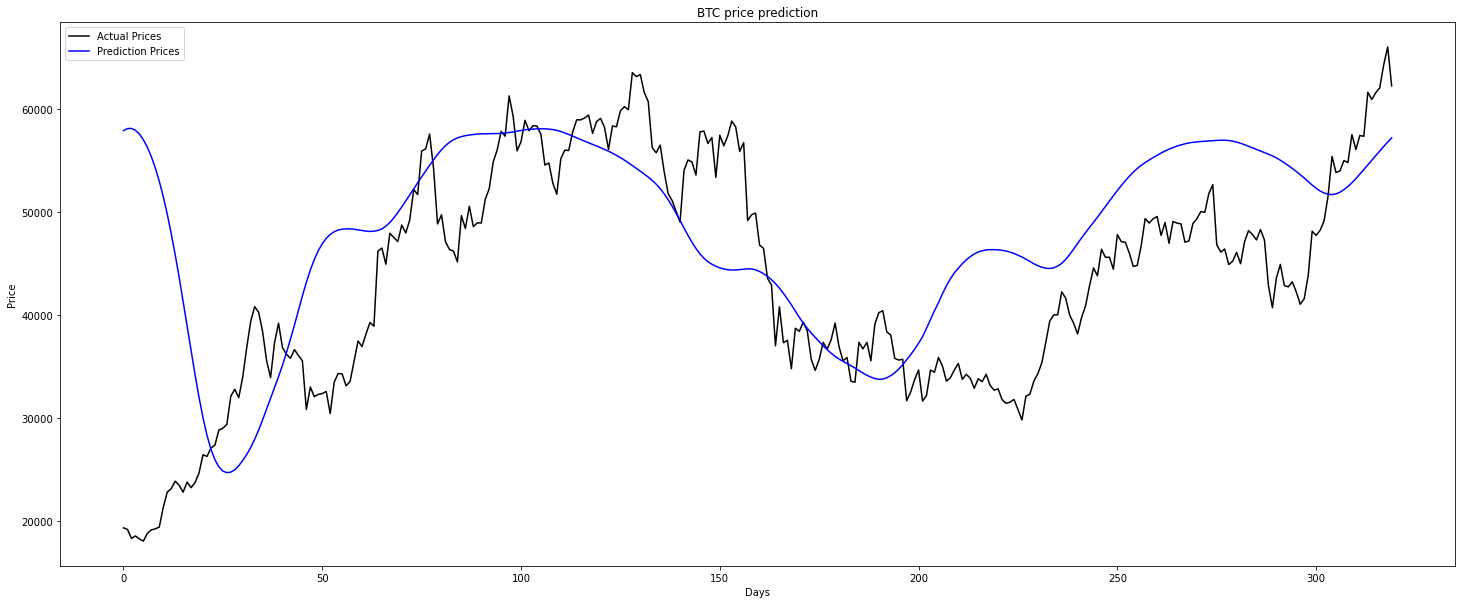

array([[57541.953]], dtype=float32)

In [23]:
preparation(df2)
#6 month

Epoch 1/25
32/32 [==============================] - 9s 76ms/step - loss: 0.0408
Epoch 2/25
32/32 [==============================] - 2s 68ms/step - loss: 0.0185
Epoch 3/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0155
Epoch 4/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0134
Epoch 5/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0127
Epoch 6/25
32/32 [==============================] - 2s 74ms/step - loss: 0.0119
Epoch 7/25
32/32 [==============================] - 2s 77ms/step - loss: 0.0100
Epoch 8/25
32/32 [==============================] - 2s 66ms/step - loss: 0.0088
Epoch 9/25
32/32 [==============================] - 2s 65ms/step - loss: 0.0099
Epoch 10/25
32/32 [==============================] - 2s 65ms/step - loss: 0.0087
Epoch 11/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0084
Epoch 12/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0090
Epoch 13/25
32/32 [==================

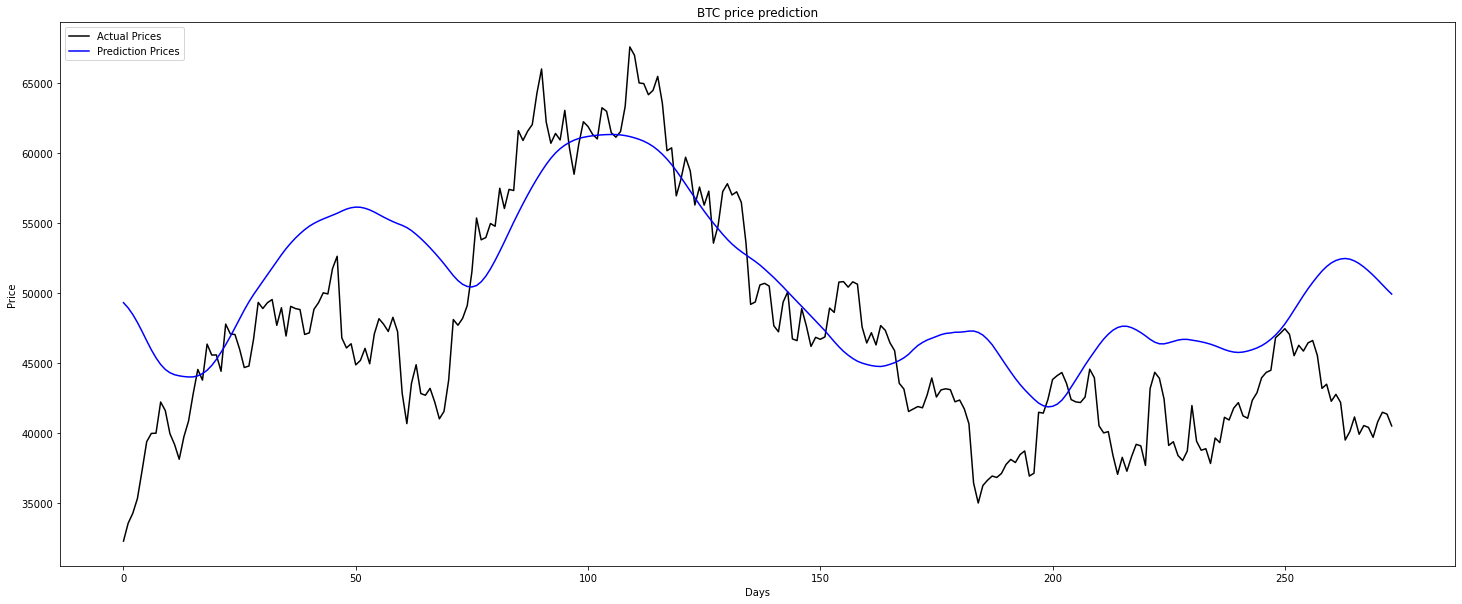

array([[49623.965]], dtype=float32)

In [24]:
preparation(df)
#current